In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import json
import os
import numpy as np
import glob
from pprint import pprint
from modelzipper.tutils import *
from matplotlib.colors import ListedColormap, BoundaryNorm

/mnt/petrelfs/tangzecheng/anaconda3/envs/zecheng/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModelZipper is ready for launch🚀 | Current Version🦄 >>> 0.2.7 <<< | AOE Time🕒 2025-01-21 03:26:46


In [61]:
hop_files = auto_read_dir("/mnt/petrelfs/tangzecheng/MyRLHF/reetrievalheaddetect/attention_analysis/attention_score", file_prefix='4-hop*', file_suffix='*json')
pprint(hop_files)


2025-01-21 01:01:17.852 | INFO     | modelzipper.tutils:auto_read_dir:371 - number of files with prefix '4-hop*' and suffix '*json': 5


['/mnt/petrelfs/tangzecheng/MyRLHF/reetrievalheaddetect/attention_analysis/attention_score/4-hop-7900.json',
 '/mnt/petrelfs/tangzecheng/MyRLHF/reetrievalheaddetect/attention_analysis/attention_score/4-hop-3900.json',
 '/mnt/petrelfs/tangzecheng/MyRLHF/reetrievalheaddetect/attention_analysis/attention_score/4-hop-1900.json',
 '/mnt/petrelfs/tangzecheng/MyRLHF/reetrievalheaddetect/attention_analysis/attention_score/4-hop-0.json',
 '/mnt/petrelfs/tangzecheng/MyRLHF/reetrievalheaddetect/attention_analysis/attention_score/4-hop-11900.json']


### 长上下文

/mnt/petrelfs/tangzecheng/MyRLHF/paper_figure/preliminary/fact_retrieval_score/4-hop-7900.pdf
begin to read data from /mnt/petrelfs/tangzecheng/MyRLHF/reetrievalheaddetect/attention_analysis/attention_score/4-hop-7900.json | file size: 177.56 KB | file type: json
/mnt/petrelfs/tangzecheng/MyRLHF/paper_figure/preliminary/fact_retrieval_score/4-hop-3900.pdf
begin to read data from /mnt/petrelfs/tangzecheng/MyRLHF/reetrievalheaddetect/attention_analysis/attention_score/4-hop-3900.json | file size: 177.74 KB | file type: json
/mnt/petrelfs/tangzecheng/MyRLHF/paper_figure/preliminary/fact_retrieval_score/4-hop-1900.pdf
begin to read data from /mnt/petrelfs/tangzecheng/MyRLHF/reetrievalheaddetect/attention_analysis/attention_score/4-hop-1900.json | file size: 177.79 KB | file type: json
/mnt/petrelfs/tangzecheng/MyRLHF/paper_figure/preliminary/fact_retrieval_score/4-hop-0.pdf
begin to read data from /mnt/petrelfs/tangzecheng/MyRLHF/reetrievalheaddetect/attention_analysis/attention_score/4-ho

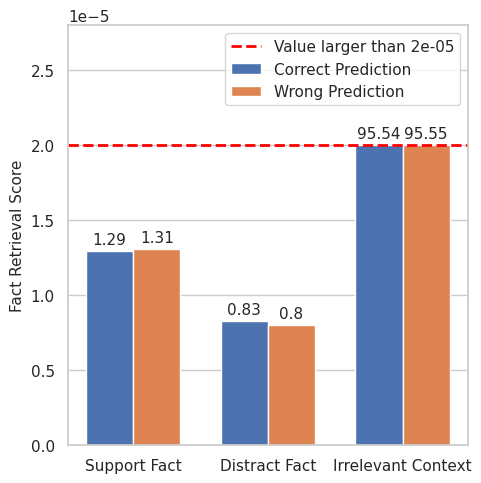

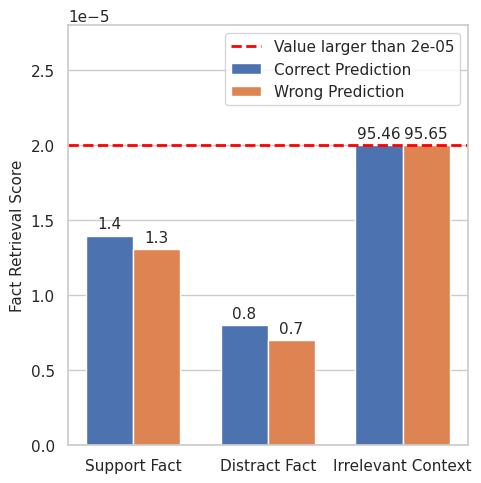

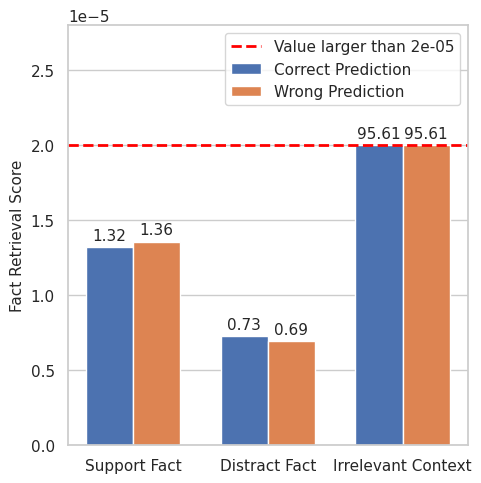

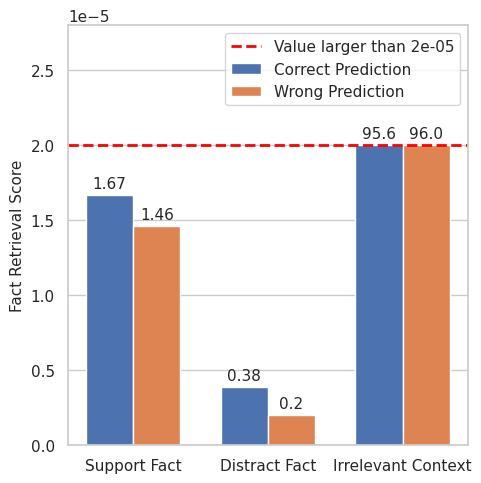

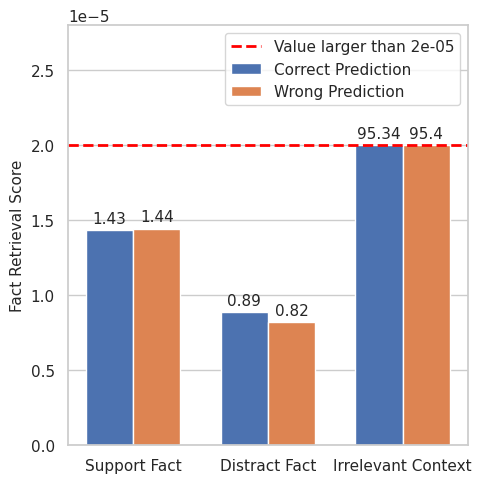

In [63]:
def statistic_attention_score(score_dict):
    """
    There are three types of attention scores:
    1. clue_pos
    2. attack_pos
    3. irrelevant_pos
    """
    succ_head_counter = score_dict['succ_head_counter']
    fail_head_counter = score_dict['fail_head_counter']

    success_clue_score = np.mean([x['clue_pos'] for x in succ_head_counter.values()])
    fail_clue_score = np.mean([x['clue_pos'] for x in fail_head_counter.values()])
    success_attack_score = np.mean([x['attack_pos'] for x in succ_head_counter.values()])
    fail_attack_score = np.mean([x['attack_pos'] for x in fail_head_counter.values()])
    success_irrelevant_score = np.mean([x['irrelevant_pos'] for x in succ_head_counter.values()])
    fail_irrelevant_score = np.mean([x['irrelevant_pos'] for x in fail_head_counter.values()])

    return success_clue_score, success_attack_score, success_irrelevant_score, fail_clue_score, fail_attack_score, fail_irrelevant_score


def draw(data, file_path=None):
    sns.set_theme(style="whitegrid")
    success_clue_score, success_attack_score, success_irrelevant_score, fail_clue_score, fail_attack_score, fail_irrelevant_score = data
    labels = ['Support Fact', 'Distract Fact', 'Irrelevant Context']

    y_upper_limit = 2e-5  # the upper limit of y-axis

    x = np.arange(len(labels))
    width = 0.35  # 柱状图的宽度

    # 绘制柱状图
    fig, ax = plt.subplots(figsize=(5, 5))
    rects1 = ax.bar(x - width/2, list(map(lambda x: x if x < y_upper_limit else y_upper_limit, [success_clue_score, success_attack_score, success_irrelevant_score])), width, label='Correct Prediction')
    rects2 = ax.bar(x + width/2, list(map(lambda x: x if x < y_upper_limit else y_upper_limit, [fail_clue_score, fail_attack_score, fail_irrelevant_score])), width, label='Wrong Prediction')

    ax.set_ylim(0, 2.8e-5)  # set ylim
    ax.xaxis.grid(False)

    if max(data) > y_upper_limit:
        ax.axhline(y=y_upper_limit, color='red', linestyle='--', linewidth=2, label=f'Value larger than {y_upper_limit}')

    # 添加一些文本标签、标题和自定义x轴标签
    ax.set_ylabel('Fact Retrieval Score', fontsize=11)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=11)
    ax.legend(fontsize=11)
    ax.tick_params(axis='x', labelsize=11)  # 设置横坐标字体大小
    ax.tick_params(axis='y', labelsize=11)  # 设置纵坐标字体大小
    # 在柱状图上显示数值

    def autolabel(rects, score_list):
        for rect, score in zip(rects, score_list):
            ax.annotate('{}'.format(round(score / 1e-5, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=11)
    autolabel(rects1, [success_clue_score, success_attack_score, success_irrelevant_score])
    autolabel(rects2, [fail_clue_score, fail_attack_score, fail_irrelevant_score])
    fig.tight_layout()
    # plt.show()

    if file_path:
        plt.savefig(file_path)


for file in hop_files:
    save_file_name = os.path.join("/mnt/petrelfs/tangzecheng/MyRLHF/paper_figure/preliminary/fact_retrieval_score", f"{os.path.basename(file).split('.')[0]}.pdf")
    print(save_file_name)
    res = statistic_attention_score(auto_read_data(file))
    if os.path.basename(file).split('.')[0].split('-')[-1] == '0':
        res[2] = 0; res[-1] = 0   # for short context testing, it has no relevant long-context
    draw(res, save_file_name)

#### 短文本上的multihop reasoning

1.29
0.83
95.54
1.31
0.8
95.55


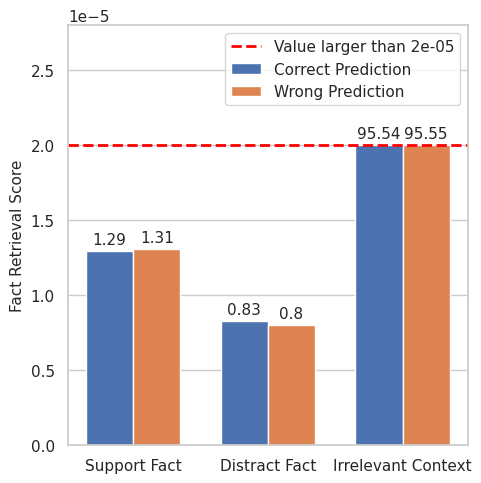

In [54]:
data = 1.67e-5, 0.38e-5, 0, 1.44e-5, 0.82e-5, 0

#### 长文本上的multihop reasoning

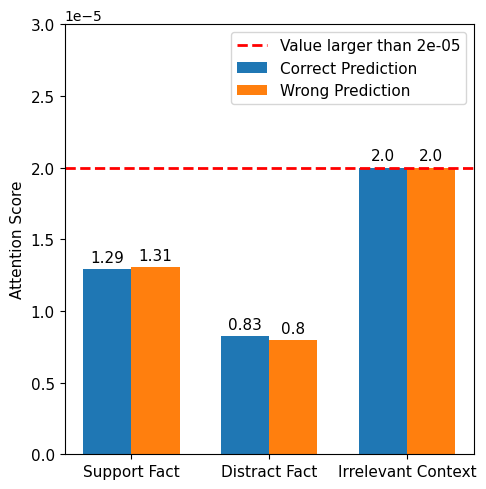

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")
success_clue_score, success_attack_score, success_irrelevant_score, fail_clue_score, fail_attack_score, fail_irrelevant_score = res
labels = ['Support Fact', 'Distract Fact', 'Irrelevant Context']

y_upper_limit = 2e-5  # the upper limit of y-axis

x = np.arange(len(labels))
width = 0.35  # 柱状图的宽度

# 绘制柱状图
fig, ax = plt.subplots(figsize=(5, 5))
rects1 = ax.bar(x - width/2, list(map(lambda x: x if x < y_upper_limit else y_upper_limit, [success_clue_score, success_attack_score, success_irrelevant_score])), width, label='Correct Prediction')
rects2 = ax.bar(x + width/2, list(map(lambda x: x if x < y_upper_limit else y_upper_limit, [fail_clue_score, fail_attack_score, fail_irrelevant_score])), width, label='Wrong Prediction')

ax.set_ylim(0, 2.8e-5)  # set ylim
ax.xaxis.grid(False)
ax.axhline(y=y_upper_limit, color='red', linestyle='--', linewidth=2, label=f'Value larger than {y_upper_limit}')

# 添加一些文本标签、标题和自定义x轴标签
ax.set_ylabel('Fact Retrieval Score', fontsize=11)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.legend(fontsize=11)
ax.tick_params(axis='x', labelsize=11)  # 设置横坐标字体大小
ax.tick_params(axis='y', labelsize=11)  # 设置纵坐标字体大小
# 在柱状图上显示数值

def autolabel(rects, score_list):
    for rect, score in zip(rects, score_list):
        print(round(score / 1e-5, 2))
        ax.annotate('{}'.format(round(score / 1e-5, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11)

autolabel(rects1, [success_clue_score, success_attack_score, success_irrelevant_score])
autolabel(rects2, [fail_clue_score, fail_attack_score, fail_irrelevant_score])

fig.tight_layout()

plt.show()

In [20]:
rects1[0].get_height()

1.2927349261076086e-05

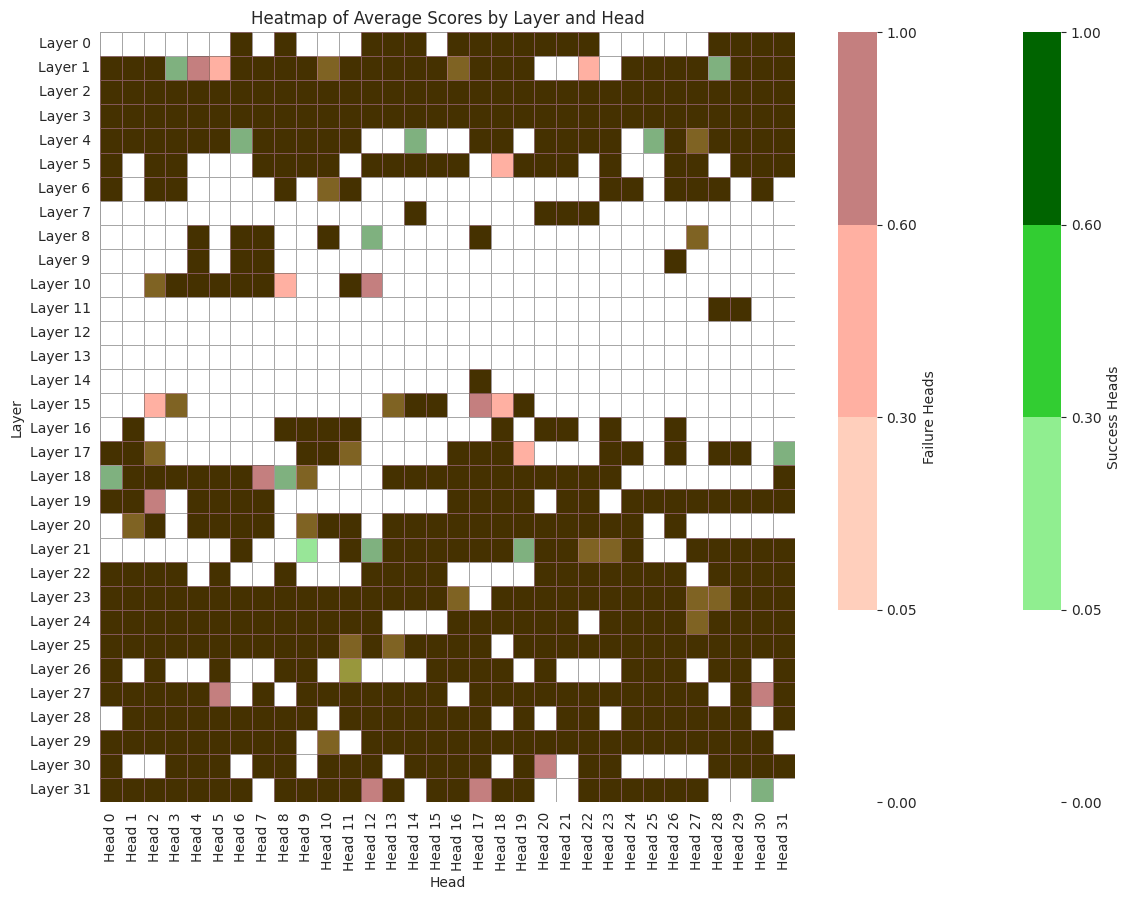

In [5]:
num_layers = 32
num_heads = 32
df_succ_scores = np.zeros((num_layers, num_heads))
df_fail_scores = np.zeros((num_layers, num_heads))

for key, values in succ_head_score.items():
    layer, head = map(int, key.split('-'))
    df_succ_scores[layer, head] = np.mean(values)

for key, values in fail_head_score.items():
    layer, head = map(int, key.split('-'))
    df_fail_scores[layer, head] = np.mean(values)

colors1 = ['#ffffff', '#90ee90', '#32cd32', '#006400']  # 浅绿 -> 中绿 -> 深绿
colors2 = ['#ffffff', '#ffa07a', '#ff6347', '#8b0000']  # 浅红 -> 中红 -> 深红
bounds = [0, 0.05, 0.3, 0.6, 1.0]  # 定义边界

# 创建colormap和norm
cmap1 = ListedColormap(colors1)
cmap2 = ListedColormap(colors2)
norm = BoundaryNorm(bounds, len(colors1))

# 转换为 DataFrame
df_succ_scores = pd.DataFrame(df_succ_scores, columns=[f'Head {i}' for i in range(num_heads)], 
                  index=[f'Layer {i}' for i in range(num_layers)])
df_fail_scores = pd.DataFrame(df_fail_scores, columns=[f'Head {i}' for i in range(num_heads)], 
                  index=[f'Layer {i}' for i in range(num_layers)])

sns.set_style("white")

fail_column_means = df_fail_scores.mean() # 计算每列的平均分
succ_column_means = df_succ_scores.mean()

# 使用apply函数，沿着列的方向（axis=0）应用一个函数
# 这个函数会检查每一个元素，如果元素值低于其所在列的平均分，那么该元素值将被设置为0
df_succ_scores = df_succ_scores.apply(lambda x: [value if value >= succ_column_means[x.name] else 0 for value in x], axis=0)
df_fail_scores = df_fail_scores.apply(lambda x: [value if value >= fail_column_means[x.name] else 0 for value in x], axis=0)

succ_heads = df_succ_scores 
fail_heads = df_fail_scores 

# 绘制热力图
plt.figure(figsize=(14, 10))

sns.heatmap(succ_heads, cmap=cmap1, norm=norm, alpha=1, cbar=True, 
            cbar_kws={'label': 'Success Heads'}, linewidths=0.5, linecolor='gray')

sns.heatmap(fail_heads, cmap=cmap2, norm=norm, alpha=0.5, cbar=True, 
            cbar_kws={'label': 'Failure Heads'}, linewidths=0.5, linecolor='gray')

plt.title('Heatmap of Average Scores by Layer and Head')
plt.xlabel('Head')
plt.ylabel('Layer')
plt.show()

In [5]:
succ_heads > succ_heads.mean()

,Head 0,Head 1,Head 2,Head 3,Head 4,Head 5,Head 6,Head 7,Head 8,Head 9,...,Head 22,Head 23,Head 24,Head 25,Head 26,Head 27,Head 28,Head 29,Head 30,Head 31
Layer 0,False,False,False,True,True,True,True,False,True,True,...,True,True,False,False,False,False,True,True,True,True
Layer 1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Layer 2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Layer 3,True,True,True,True,True,True,True,True,False,True,...,True,True,True,True,True,True,False,True,True,True
Layer 4,True,True,True,True,False,False,False,False,False,False,...,False,True,False,False,False,False,True,True,True,False
Layer 5,False,False,False,False,False,False,False,False,True,True,...,False,True,False,False,False,False,False,False,False,False
Layer 6,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Layer 7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Layer 8,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Layer 9,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


下面是分析Reasoning Head 和 Retrieval Head 之间的关系

In [ ]:
# head_reasoning_file = "/data/zecheng/acl2025/MyRLHF/RetrievalHead/reetrievalheaddetect/head_score/q3_inf_diff_pos/Meta-Llama-3.1-8B-Instruct.json"
# head_score_file = "/data/zecheng/acl2025/MyRLHF/RetrievalHead/reetrievalheaddetect/head_score/niah_retrieval/Meta-Llama-3.1-8B-Instruct.json"
head_reasoning_file = "/data/zecheng/acl2025/MyRLHF/reetrievalheaddetect/head_score/q3_inf_diff_pos/Qwen2.5-7B-Instruct.json"
head_score_file = "/data/zecheng/acl2025/MyRLHF/reetrievalheaddetect/head_score/niah_retrieval/Qwen2.5-7B-Instruct.json"
reason_scores = auto_read_data(head_reasoning_file)
retrieval_scores = auto_read_data(head_score_file)

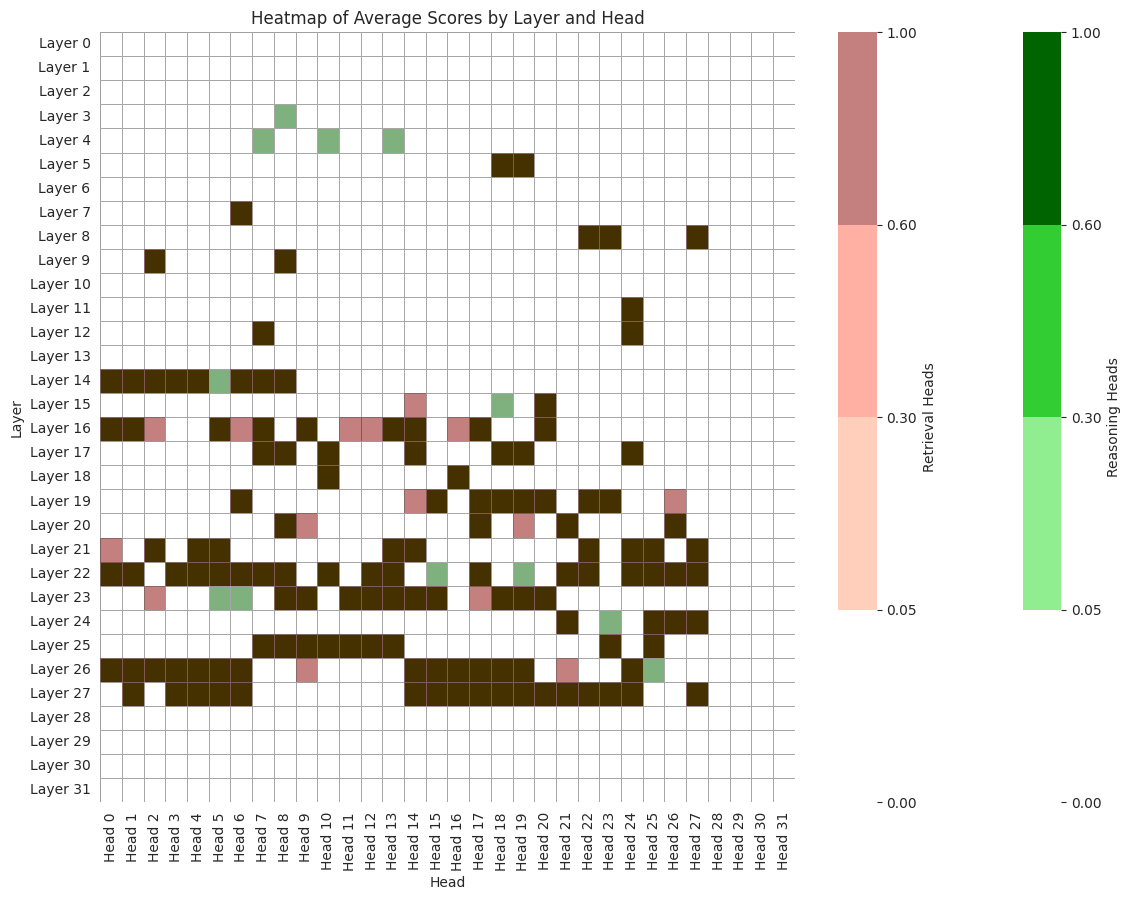

In [6]:
num_layers = 32
num_heads = 32
df_reason_scores = np.zeros((num_layers, num_heads))
df_retrieval_scores = np.zeros((num_layers, num_heads))

for key, values in reason_scores.items():
    layer, head = map(int, key.split('-'))
    df_reason_scores[layer, head] = np.mean(values)

for key, values in retrieval_scores.items():
    layer, head = map(int, key.split('-'))
    df_retrieval_scores[layer, head] = np.mean(values)

colors1 = ['#ffffff', '#90ee90', '#32cd32', '#006400']  # 浅绿 -> 中绿 -> 深绿
colors2 = ['#ffffff', '#ffa07a', '#ff6347', '#8b0000']  # 浅红 -> 中红 -> 深红
bounds = [0, 0.05, 0.3, 0.6, 1.0]  # 定义边界

# 创建colormap和norm
cmap1 = ListedColormap(colors1)
cmap2 = ListedColormap(colors2)
norm = BoundaryNorm(bounds, len(colors1))

# 转换为 DataFrame
df_reason_scores = pd.DataFrame(df_reason_scores, columns=[f'Head {i}' for i in range(num_heads)], 
                  index=[f'Layer {i}' for i in range(num_layers)])
df_retrieval_scores = pd.DataFrame(df_retrieval_scores, columns=[f'Head {i}' for i in range(num_heads)], 
                  index=[f'Layer {i}' for i in range(num_layers)])

sns.set_style("white")

reasoning_heads = df_reason_scores > 0.1
retrieval_heads = df_retrieval_scores > 0.1

# 绘制热力图
plt.figure(figsize=(14, 10))

sns.heatmap(reasoning_heads, cmap=cmap1, norm=norm, alpha=1, cbar=True, 
            cbar_kws={'label': 'Reasoning Heads'}, linewidths=0.5, linecolor='gray')

sns.heatmap(retrieval_heads, cmap=cmap2, norm=norm, alpha=0.5, cbar=True, 
            cbar_kws={'label': 'Retrieval Heads'}, linewidths=0.5, linecolor='gray')

plt.title('Heatmap of Average Scores by Layer and Head')
plt.xlabel('Head')
plt.ylabel('Layer')
plt.show()

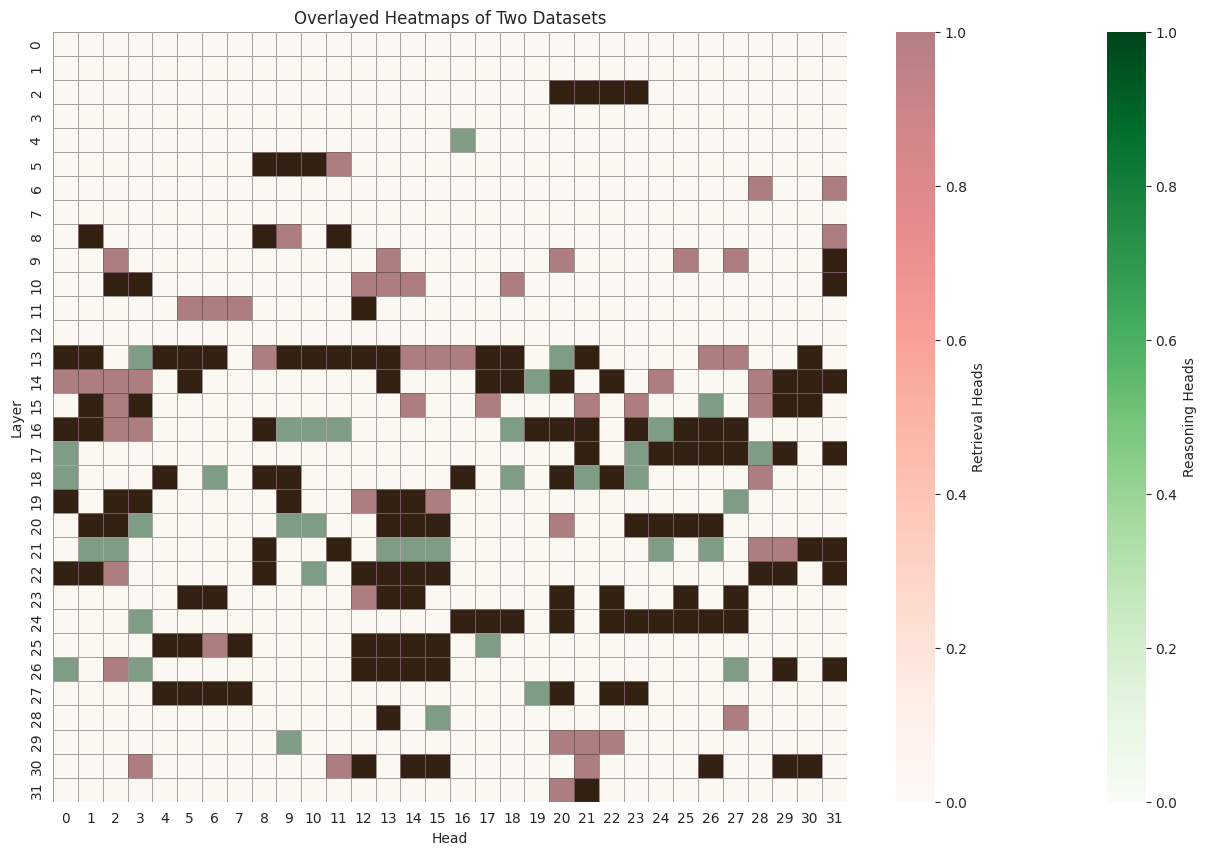

In [5]:
num_layers = 32
num_heads = 32
df_reason_scores = np.zeros((num_layers, num_heads))
df_retrieval_scores = np.zeros((num_layers, num_heads))

for key, values in reason_scores.items():
    layer, head = map(int, key.split('-'))
    df_reason_scores[layer, head] = np.mean(values)

for key, values in retrieval_scores.items():
    layer, head = map(int, key.split('-'))
    df_retrieval_scores[layer, head] = np.mean(values)

reasoning_heads = df_reason_scores > 0.1
retrieval_heads = df_retrieval_scores > 0.1

plt.figure(figsize=(16, 10))
sns.heatmap(reasoning_heads, cmap='Greens', alpha=1, cbar=True, 
            cbar_kws={'label': 'Reasoning Heads'}, linewidths=0.5, linecolor='gray')
sns.heatmap(retrieval_heads, cmap='Reds', alpha=0.5, cbar=True, 
            cbar_kws={'label': 'Retrieval Heads'}, linewidths=0.5, linecolor='gray')

plt.title('Overlayed Heatmaps of Two Datasets')
plt.xlabel('Head')
plt.ylabel('Layer')

plt.show()
